# 协程

In [55]:
def simple_coroutine():
    try:
        print('->coroutine started')
        x = yield                         # 生成器暂停并等待外部传递的值
        print('->coroutine received: ', x)  # 输出接收到的值
    except Exception as e:
        print("Traceback:", e)
        # 处理异常后，可以选择恢复生成器
        yield "Error handled"  # 返回一个错误提示值或其他信息

my_coro = simple_coroutine()
my_coro


<generator object simple_coroutine at 0x0000021E18B3C740>

In [56]:
next(my_coro)       # 启动协程, 执行到 yield 语句并暂停

->coroutine started


In [57]:
try:
    my_coro.send(42)        # 发送值到协程
except Exception as e:
    print(e)

->coroutine received:  42



#### inspect.getgeneratorstate(generator)

检查生成器（或协程）的当前状态

返回值：

返回一个字符串，表示生成器的当前状态。可能的状态包括：
- 'GEN_CREATED'：生成器已创建，尚未开始执行。
- 'GEN_RUNNING'：生成器正在运行。
- 'GEN_SUSPENDED'：生成器已暂停（通常在 yield 语句处暂停）。
- 'GEN_CLOSED'：生成器执行完成，且已经关闭。

In [58]:
import inspect      # 检查生成器（或协程）的当前状态

In [59]:
## 仅当协程处于暂停状态才能调用send
try:
    my_coro2 = simple_coroutine()   
    print(inspect.getgeneratorstate(my_coro2))  # 打印: GEN_CREATED
    my_coro.send(1024)
except:
    pass

GEN_CREATED


In [60]:
try:
    my_coro3 = simple_coroutine()
    print(inspect.getgeneratorstate(my_coro3))      # GEN_CREATED
    next(my_coro3)
    print(inspect.getgeneratorstate(my_coro3))      # GEN_SUSPENDED 在yield表达式处暂停
    my_coro3.send(2048)
except:
    pass

GEN_CREATED
->coroutine started
GEN_SUSPENDED
->coroutine received:  2048


### 

### 2 value generator

In [61]:
def simple_coro2(a):
    print('->Started: a = ', a)
    b = yield a
    print('->Received b: ', b)
    c = yield a + b
    print('->Received c = :', c)

my_coro4 = simple_coro2(14)

from inspect import getgeneratorstate
getgeneratorstate(my_coro4)

'GEN_CREATED'

In [62]:
next(my_coro4)

->Started: a =  14


14

In [63]:
getgeneratorstate(my_coro4)

'GEN_SUSPENDED'

In [64]:
my_coro4.send(100)

->Received b:  100


114

In [65]:
try:
    my_coro4.send(2000)
except Exception as e:
    print(e)

->Received c = : 2000



In [66]:
getgeneratorstate(my_coro4)

'GEN_CLOSED'

In [67]:
import sys
import traceback

def handle_exception(exc_type, exc_value, exc_tb):
    if issubclass(exc_type, KeyboardInterrupt):
        # 不处理 KeyboardInterrupt 异常
        sys.__excepthook__(exc_type, exc_value, exc_tb)
    else:
        # 捕获其他异常，防止程序中断
        print("捕获到异常:", exc_type, exc_value)
        traceback.print_exception(exc_type, exc_value, exc_tb)

sys.excepthook = handle_exception


整个过程:

各个阶段都在yield表达式中结束，而且下一个阶段都从那一行代码开始，然后再把yield表达式的值赋给变量

yield 的作用是暂停生成器并返回一个值，这个值被传递给调用生成器的地方

![屏幕截图 2025-01-02 111745.png](<attachment:屏幕截图 2025-01-02 111745.png>)

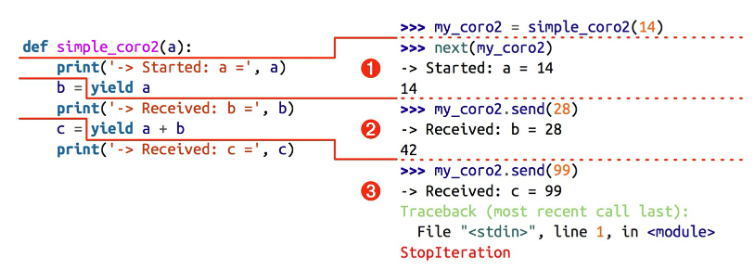

### 定义一个计算移动平均值的协程

In [71]:
def averager():
    total = 0.0    
    count = 0    
    average = None    
    while True:   # 仅当调用方在协程上调用.close()方法，或者没有对协程的引用而被垃圾回收程序回收时，这个协程才会终止   
        term = yield average        
        total += term        
        count += 1        
        average = total/count

In [72]:
coro_avg = averager()
next(coro_avg)
coro_avg.send(10)

10.0

In [74]:
coro_avg.send(30)

20.0

In [75]:
coro_avg.send(100)

46.666666666666664

In [76]:
coro_avg.close()

### 预激协程的装饰器

In [81]:
from functools import wraps

def coroutine(func):
    @wraps(func)
    def primer(*args, **kwargs):
        gen = func(*args, **kwargs)
        next(gen)   # 激活!!!
        return gen
    return primer   # 返回已经激活后的生成器

In [87]:
@coroutine
def averager_plus():
    total = 0.0    
    count = 0    
    average = None    
    while True:   # 仅当调用方在协程上调用.close()方法，或者没有对协程的引用而被垃圾回收程序回收时，这个协程才会终止   
        term = yield average        
        total += term        
        count += 1        
        average = total/count


In [92]:
my_coro = averager_plus()
print(my_coro.send(10))
print(getgeneratorstate(my_coro))

print(my_coro.send(40))
print(getgeneratorstate(my_coro))

10.0
GEN_SUSPENDED
25.0
GEN_SUSPENDED


### 止协程和异常处理

In [93]:
my_coro2 = averager_plus()
my_coro2.send('error now!')

TypeError: unsupported operand type(s) for +=: 'float' and 'str'

In [94]:
# 在协程内没有处理异常，协程会终止
my_coro2.send(10)       # 试图重新激活协程，会抛出StopIteration异常

StopIteration: 

### 协程返回值

In [95]:
from collections import namedtuple

# 定义命名元组
Result = namedtuple('Result', 'count average')  # 统计项数

def averager():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield
        if term is None:  
            break
        total += term
        count += 1
        average = total / count
    return Result(count, average)


In [97]:
coro_avg = averager()       # 创建生成器实例
next(coro_avg)              # 启动生成器并执行到第一个 yield
coro_avg.send(10)           # 向生成器发送第一个值 10
coro_avg.send(30)           # 向生成器发送第二个值 30
coro_avg.send(6.5)          # 向生成器发送第三个值 6.5
try:
    coro_avg.send(None)         # 向生成器发送 None，结束生成器并返回结果

    
except StopIteration as e:
    print('''StopIteration                             Traceback (most recent call last)
Cell In[96], line 6
      4 coro_avg.send(30)           # 向生成器发送第二个值 30
      5 coro_avg.send(6.5)          # 向生成器发送第三个值 6.5
----> 6 coro_avg.send(None)         # 向生成器发送 None，结束生成器并返回结果

StopIteration: Result(count=3, average=15.5)'''
    )


StopIteration                             Traceback (most recent call last)
Cell In[96], line 6
      4 coro_avg.send(30)           # 向生成器发送第二个值 30
      5 coro_avg.send(6.5)          # 向生成器发送第三个值 6.5
----> 6 coro_avg.send(None)         # 向生成器发送 None，结束生成器并返回结果

StopIteration: Result(count=3, average=15.5)


In [98]:
# 或者使用更简单的异常处理
coro_avg2 = averager()       # 创建生成器实例
next(coro_avg2)              # 启动生成器并执行到第一个 yield
coro_avg2.send(10)           # 向生成器发送第一个值 10
coro_avg2.send(30)           # 向生成器发送第二个值 30
coro_avg2.send(6.5)          # 向生成器发送第三个值 6.5

try:
    coro_avg2.send(None)
except StopIteration as exc:
    result = exc.value
result

Result(count=3, average=15.5)

### yield from

- 参考:[yield from](https://fantasyhh.github.io/2020/01/12/python-yield-from/)


用于简化生成器（generator）中的迭代过程。它可以将一个生成器的值直接传递给另一个生成器，而无需显式地使用 for 循环

In [1]:
# yield from x表达式对x对象所做的第一件事是，调用iter(x)，从中获取迭代器。因此，x可以是任何可迭代的对象
def gen():
    yield from "ab"
    yield from range(1, 5)

list(gen())

['a', 'b', 1, 2, 3, 4]

In [17]:
## eg2: 扁平化序列
from collections.abc import Iterable		# python3.10后使用.abc

def flatten(items, ignore_types=(str, bytes)):
	for x in items:
		if isinstance(x, Iterable) and not isinstance(x, ignore_types):
			yield from flatten(x)
		else:
			yield x

items = [1, 2, [3, 4, [5, 6], 7], 8]

for x in flatten(items):
	print(x)


print('=========================================')
items = ['Dave', 'Paula', ['Thomas', 'Lewis']]
for x in flatten(items):
	print(x)

1
2
3
4
5
6
7
8
Dave
Paula
Thomas
Lewis


In [18]:
from collections.abc import Iterable

def flatten(items, ignore_types=(str, bytes)):
    for x in items:
        print(f"Checking: {x}")  # 打印检查的项
        if isinstance(x, Iterable) and not isinstance(x, ignore_types):
            print(f"Recursing into: {x}")  # 打印递归进入的项
            yield from flatten(x)
        else:
            yield x

# 测试用例
nested_list = [1, [2, 3], [4, [5, 6]], 'hello', 7]
flattened = list(flatten(nested_list))  # 这里会触发所有的递归和打印
print(flattened)


Checking: 1
Checking: [2, 3]
Recursing into: [2, 3]
Checking: 2
Checking: 3
Checking: [4, [5, 6]]
Recursing into: [4, [5, 6]]
Checking: 4
Checking: [5, 6]
Recursing into: [5, 6]
Checking: 5
Checking: 6
Checking: hello
Checking: 7
[1, 2, 3, 4, 5, 6, 'hello', 7]


> yield from 的主要功能是打开双向通道，把最外层的调用方与最内层的子生成器连接起来，这样二者可以直接发送和产出值，还可以直接传入异常，而不用在位于中间的协程中添加大量处理异常的样板代码。有了这个结构，协程可以通过以前不可能的方式委托职责

- main的两层循环的书中解释
  - 外层for循环每次迭代会新建一个grouper实例，赋值给group变量；group是委派生成器。
  - 调用next(group)，预激委派生成器grouper，此时进入while True循环，调用子生成器averager后，在yield from表达式处暂停。
  - 内层for循环调用group.send(value)，直接把值传给子生成器averager。同时，当前的grouper实例（group）在yield from表达式处暂停。
  - 内层循环结束后，group实例依旧在yield from表达式处暂停，因此，grouper函数定义体中为results[key]赋值的语句还没有执行。
  - 如果外层for循环的末尾没有group.send(None)，那么averager子生成器永远不会终止，委派生成器group永远不会再次激活，因此永远不会为results[key]赋值。
  - 外层for循环重新迭代时会新建一个grouper实例，然后绑定到group变量上。前一个grouper实例（以及它创建的尚未终止的averager子生成器实例）被垃圾回收程序回收

In [2]:
from collections import namedtuple

Result = namedtuple('Result', 'count average')

# 子生成器
def averager():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield        # 接受来自main 的发送值, 并绑定到term
        if term is None:    # 必要的终止条件, 否则永远阻塞
            break
        total += term
        count += 1
        average = total / count
    return Result(count, average)   # 作为yield from的值

# 委派生成器
def grouper(results, key):
    while True:    # 会委托给 averager 生成器来处理传入的数据，并返回 averager 返回的结果（Result）
        '''来自书上的注解:
            grouper发送的每个值都会经由yield from处理，
            通过管道传给averager实例。
            grouper会在yield from表达式处暂停，
            等待averager实例处理客户端发来的值。
            averager实例运行完毕后，返回的值绑定到results[key]上。
            while循环会不断创建averager实例，处理更多的值'''
        results[key] = yield from averager()    # 每次循环新建一个average实例

# 客户端代码，即调用方
def main(data):
    results = {}
    for key, values in data.items():
        group = grouper(results, key)
        next(group)
        for value in values:
            group.send(value)       # 向generator发送数据
        group.send(None)  # 重要！      # 触发 averager 计算并返回结果

    # print(results)  # 如果要调试，去掉注释
    report(results)

# 输出报告
def report(results):
    for key, result in sorted(results.items()):
        group, unit = key.split(';')
        print('{:2} {:5} averaging {:.2f}{}'.format(
            result.count, group, result.average, unit))

data = {
    'girls;kg': [40.9, 38.5, 44.3, 42.2, 45.2, 41.7, 44.5, 38.0, 40.6, 44.5],
    'girls;m': [1.6, 1.51, 1.4, 1.3, 1.41, 1.39, 1.33, 1.46, 1.45, 1.43],
    'boys;kg': [39.0, 40.8, 43.2, 40.8, 43.1, 38.6, 41.4, 40.6, 36.3],
    'boys;m': [1.38, 1.5, 1.32, 1.25, 1.37, 1.48, 1.25, 1.49, 1.46],
}

if __name__ == '__main__':
    main(data)


 9 boys  averaging 40.42kg
 9 boys  averaging 1.39m
10 girls averaging 42.04kg
10 girls averaging 1.43m
